# Importing the data and needed libraries

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from statistics import mean
from sklearn.metrics import f1_score, recall_score, hamming_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import accuracy_score
from nltk.tokenize import TweetTokenizer 
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns
import pandas as pd
import nltk
import re
import csv

nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
data = pd.read_csv('/content/codeless (8).csv')

train_df = data[:int(len(data)*0.7)].dropna()
test_df = data[int(len(data)*0.7):].dropna()

In [ ]:
display(train_df)

,ID,Comment,Repository Name,Repository Owner,Negative Probability,Neutral Probability,Positive Probability,Label
0,1,workaround patch AppArmor profile reload profi...,microk8s,ubuntu,0.748957,0.716268,0.251043,neutral
1,2,discussed correction previous merge,microk8s,ubuntu,0.435867,0.426106,0.564133,pos
2,3,said merging get snap review get back,microk8s,ubuntu,0.566488,0.433525,0.433512,neg
3,4,going self merge review PR get time,microk8s,ubuntu,0.498335,0.351318,0.501665,pos
4,5,minor fix yesterdays commit,microk8s,ubuntu,0.478396,0.592092,0.521604,neutral
...,...,...,...,...,...,...,...,...
10799,10800,jwt token used get real token right Adding one...,Grasscutter,Grasscutters,0.482842,0.165752,0.517158,pos
10800,10801,Great mark ready review FYI anyone going use g...,Grasscutter,Grasscutters,0.367428,0.185404,0.632572,pos
10801,10802,problem pc,Grasscutter,Grasscutters,0.649210,0.635760,0.350790,neutral
10802,10803,send PublicIp ca unless running server client ...,Grasscutter,Grasscutters,0.639104,0.329685,0.360896,neg


In [ ]:
display(test_df)

,ID,Comment,Repository Name,Repository Owner,Negative Probability,Neutral Probability,Positive Probability,Label
10804,10805,GitHub adds commits automatically merging PR w...,Grasscutter,Grasscutters,0.677560,0.391704,0.322440,neg
10805,10806,GitHub adds commits automatically merging PR w...,Grasscutter,Grasscutters,0.514773,0.391845,0.485227,neg
10806,10807,Consider suggestion Tagging individually,Grasscutter,Grasscutters,0.527600,0.399054,0.472400,neg
10807,10808,looks like PublicIp wrong client ca connect IP...,Grasscutter,Grasscutters,0.810856,0.196620,0.189144,neg
10808,10809,solved seems public server sorry ask clarifica...,Grasscutter,Grasscutters,0.817274,0.173149,0.182726,neg
...,...,...,...,...,...,...,...,...
15428,15429,looks fine quite tests fail,opencv,opencv,0.584945,0.236416,0.415055,neg
15431,15432,formula change fine update tests,opencv,opencv,0.416703,0.172891,0.583297,pos
15432,15433,Thank modify tests solid parameters avoid zero...,opencv,opencv,0.371980,0.156302,0.628020,pos
15433,15434,Updated perf tests,opencv,opencv,0.524892,0.751777,0.475108,neutral


In [ ]:
train_df = train_df[['Comment', 'Label']]

one_hot = pd.get_dummies(train_df['Label'])
train_df = train_df.drop('Label',axis = 1)
train_df = train_df.join(one_hot)

In [ ]:
test_df = test_df[['Comment', 'Label']]

one_hot = pd.get_dummies(test_df['Label'])
test_df = test_df.drop('Label',axis = 1)
test_df = test_df.join(one_hot)

In [ ]:
display(train_df)

,Comment,neg,neutral,pos
0,workaround patch AppArmor profile reload profi...,0,1,0
1,discussed correction previous merge,0,0,1
2,said merging get snap review get back,1,0,0
3,going self merge review PR get time,0,0,1
4,minor fix yesterdays commit,0,1,0
...,...,...,...,...
10799,jwt token used get real token right Adding one...,0,0,1
10800,Great mark ready review FYI anyone going use g...,0,0,1
10801,problem pc,0,1,0
10802,send PublicIp ca unless running server client ...,1,0,0


In [ ]:
def get_label_value(lab):
  if lab == 'neg':
    return 0
  elif lab == 'pos':
    return 1
  else:
    return 2


train_df_labels_multy = data[:int(len(data)*0.7)]
train_df_labels_multy = train_df_labels_multy[['Comment', 'Label']]
train_df_labels_multy['Label'] = train_df_labels_multy['Label'] = train_df_labels_multy['Label'].map(lambda lab : get_label_value(lab))


test_df_labels_multy = data[int(len(data)*0.7):]
test_df_labels_multy = test_df_labels_multy[['Comment', 'Label']]
test_df_labels_multy['Label'] = test_df_labels_multy['Label'] = test_df_labels_multy['Label'].map(lambda lab : get_label_value(lab))

In [ ]:
display(train_df_labels_multy)

,Comment,Label
0,workaround patch AppArmor profile reload profi...,2
1,discussed correction previous merge,1
2,said merging get snap review get back,0
3,going self merge review PR get time,1
4,minor fix yesterdays commit,2
...,...,...
10799,jwt token used get real token right Adding one...,1
10800,Great mark ready review FYI anyone going use g...,1
10801,problem pc,2
10802,send PublicIp ca unless running server client ...,0


In [ ]:
display(test_df_labels_multy)

,Comment,Label
10804,GitHub adds commits automatically merging PR w...,0
10805,GitHub adds commits automatically merging PR w...,0
10806,Consider suggestion Tagging individually,0
10807,looks like PublicIp wrong client ca connect IP...,0
10808,solved seems public server sorry ask clarifica...,0
...,...,...
15430,NaN,2
15431,formula change fine update tests,1
15432,Thank modify tests solid parameters avoid zero...,1
15433,Updated perf tests,2


In [ ]:
labels = ['neg','neutral','pos']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


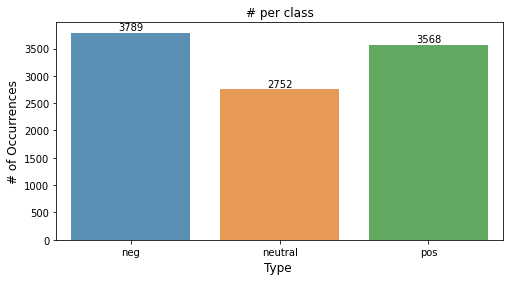

In [ ]:
x=train_df.iloc[:,1:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
p_labels = x.values
for rect, label in zip(rects, p_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


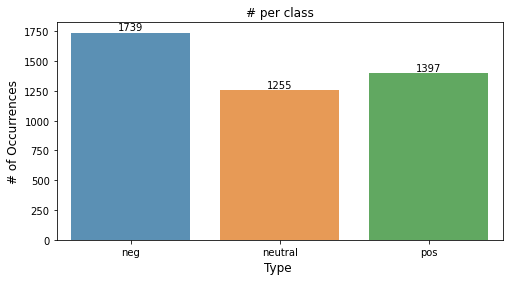

In [ ]:
x=test_df.iloc[:,1:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
p_labels = x.values
for rect, label in zip(rects, p_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
from wordcloud import WordCloud

In [ ]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train_df[train_df[token] == 1]
    threat_text = threat_context.Comment
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800, collocations = False,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words associated with {token} comment", size=20)
    plt.show()

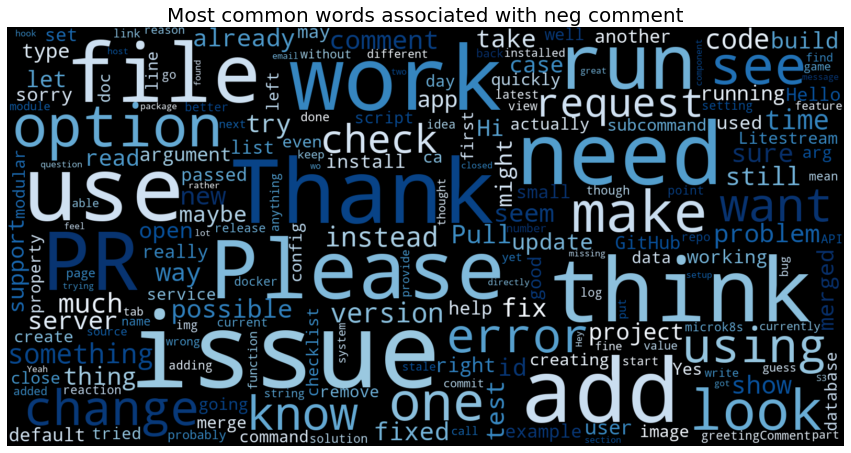

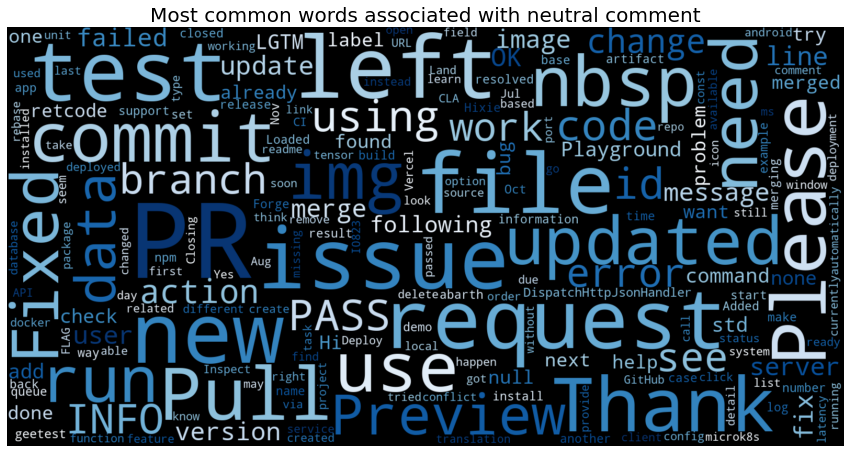

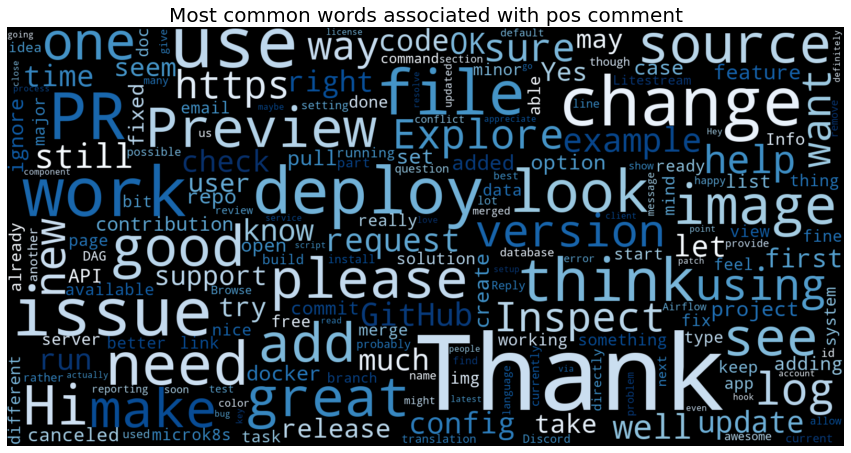

In [ ]:
for label in labels:
  W_Cloud(label)

# Preprocessing

In [ ]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
eng_stopwords = set(stopwords.words("english"))
lem = nltk.WordNetLemmatizer()
tokenizer=TweetTokenizer()

In [ ]:
def clean_text(comment):
    """
    This function receives comments and returns clean word-list
    """
    if isinstance(comment, float):
      return ""
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words= tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
train_df['Comment'] = train_df['Comment'].map(lambda com : clean_text(com))
train_df_labels_multy['Comment'] = train_df_labels_multy['Comment'].map(lambda com : clean_text(com))

In [ ]:
test_df['Comment'] = test_df['Comment'].map(lambda com : clean_text(com))
test_df_labels_multy['Comment'] = test_df_labels_multy['Comment'].map(lambda com : clean_text(com))

In [ ]:
X = train_df.Comment
test_X = test_df.Comment

In [ ]:
print(X.shape, test_X.shape)

(10109,) (4391,)


# Model

In [ ]:
# import and instantiate TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')

In [ ]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
X_dtm_multy = vect.fit_transform(train_df_labels_multy.Comment)

# examine the document-term matrix created from X_train
X_dtm

<10109x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 101248 stored elements in Compressed Sparse Row format>

In [ ]:
X_dtm.shape

(10109, 5000)

In [ ]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
test_X_dtm_multy = vect.transform(test_df_labels_multy.Comment)

# examine the document-term matrix from X_test
test_X_dtm

<4391x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 43393 stored elements in Compressed Sparse Row format>

In [ ]:
# import gensim
# import gensim.downloader as api

# corpus = X

# ## create list of lists of unigrams
# lst_corpus = []
# for string in corpus:
#    lst_words = string.split()
#    lst_grams = [" ".join(lst_words[i:i+1]) 
#                for i in range(0, len(lst_words), 1)]
#    lst_corpus.append(lst_grams)

# ## detect bigrams and trigrams
# bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
#                  delimiter=" ".encode(), min_count=5, threshold=10)
# bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
# trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
#             delimiter=" ".encode(), min_count=5, threshold=10)
# trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
# nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
#             window=8, min_count=1, sg=1, iter=30)

In [ ]:
# from tensorflow.keras import models, layers, preprocessing as kprocessing

# ## tokenize text
# tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
#                      oov_token="NaN", 
#                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
# tokenizer.fit_on_texts(lst_corpus)
# dic_vocabulary = tokenizer.word_index
# ## create sequence
# lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
# ## padding sequence
# X_train_word2vec_embbedings = kprocessing.sequence.pad_sequences(lst_text2seq, 
#                     maxlen=15, padding="post", truncating="post")

In [ ]:
# def create_embed(sent): 
#   sent_vect = np.zeros(0)
#   for word in sent.split():
#     if word in nlp:
#       sent_vect = np.concatenate( (sent_vect, nlp[word]), axis = 0 )
#       if sent_vect.shape[0] > 5000:
#         sent_vect = sent_vect[:5000]
#         break
#   sent_vect = np.concatenate((sent_vect, np.zeros(5000 - sent_vect.shape[0])), axis = 0 )
#   if sent_vect.shape[0] != 5000:
#     return np.zeros(5000)
#   return sent_vect


In [ ]:
# print(X.shape)
# print(X)

In [ ]:
# print(X[0])

In [ ]:
# word2vec_embed = X.map(lambda com : create_embed(str(com)))

In [ ]:
# word2vec_embed[1].shape

In [ ]:
# X_dtm_multy.shape

Using SVM:

In [ ]:
import numpy as np

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decisions(X, y, model):
  fig, ax = plt.subplots()
  # title for the plots
  title = (f'Decision surface of {model} ')
  # Set-up grid for plotting.
  X0, X1 = X[:, 0], X[:, 1]
  xx, yy = make_meshgrid(X0, X1)
  plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
  ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
  ax.set_ylabel('y label here')
  ax.set_xlabel('x label here')
  ax.set_xticks(())
  ax.set_yticks(())
  ax.set_title(title)
  ax.legend()
  plt.show()
  return 

In [ ]:
from sklearn.manifold import TSNE

# Reduce vectors dimensions using TSNE
embeddings_2d = TSNE(n_components=2, learning_rate='auto',
                     init='random').fit_transform(X_dtm[:10000])


In [ ]:
target = train_df_labels_multy['Label'].values
print(target)


[2 1 0 ... 2 0 0]


<function matplotlib.pyplot.show>

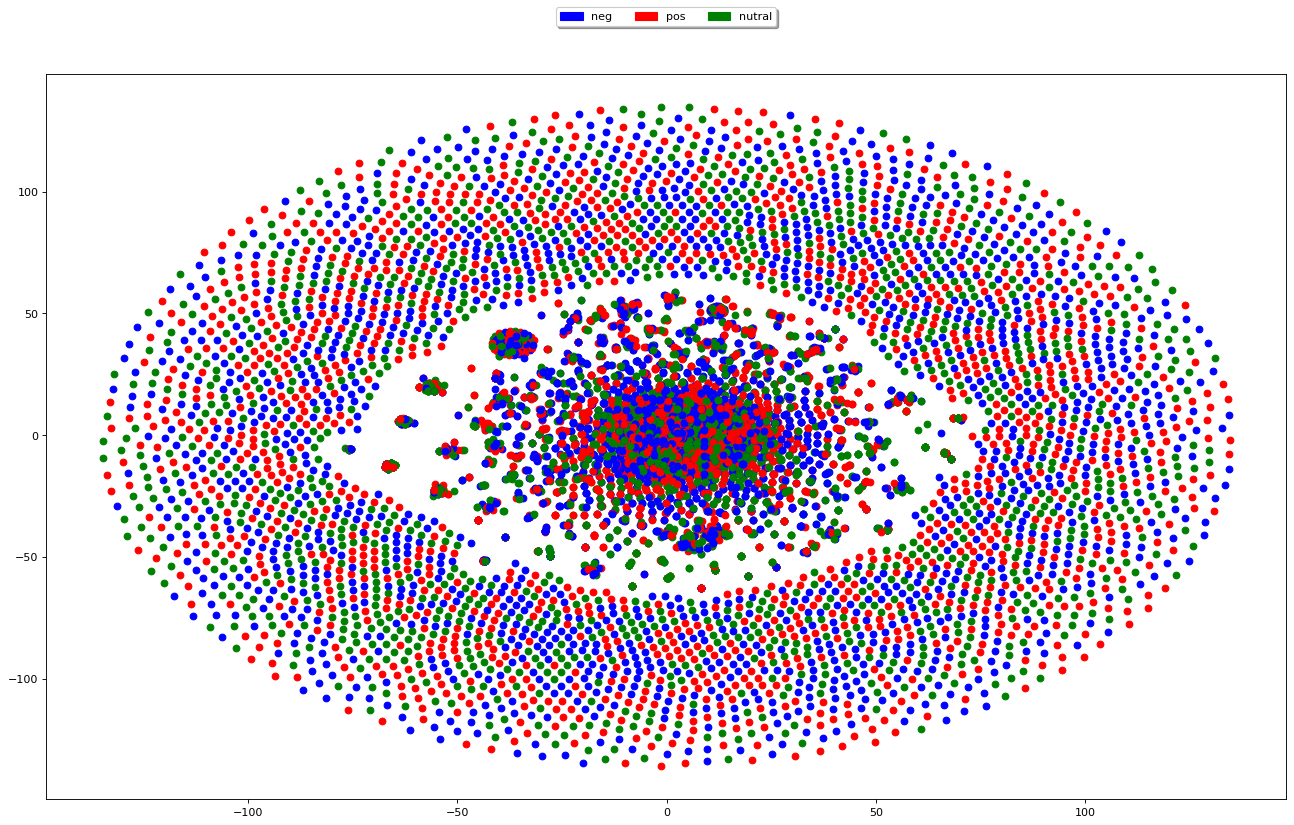

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

# Plot
figure(figsize=(20, 12), dpi=80)

i = 0
for x,y in embeddings_2d:

    if target[i] == 0:
        plt.plot(x,y,'o',color='b', label='neg')
    elif target[i] == 1:
        plt.plot(x,y,'o',color='r', label='pos')
    else:
      plt.plot(x,y,'o',color='g', label='nutral')
      
    i += 1
patches = []

neg_patch = mpatches.Patch(color='b', label='neg')
patches.append(neg_patch)
pos_patch = mpatches.Patch(color='r', label='pos')
patches.append(pos_patch)
nutral_patch = mpatches.Patch(color='g', label='nutral')
patches.append(nutral_patch)

plt.legend(handles=patches,loc='upper center', bbox_to_anchor=(0.5, 1.1),
           ncol=10, fancybox=True, shadow=True)
plt.show

In [ ]:
X_dtm_multy.shape

(10804, 5000)

In [ ]:
# word2vec_embed.shape

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#best parameters using grid search
svm = SVC(kernel = 'rbf', C=2, degree = 1 )


y = train_df_labels_multy['Label']
svm.fit(X_dtm_multy, y)


svm_pred = svm.predict(X_dtm_multy)
print(f"training accuracy_score: {accuracy_score(y, svm_pred)}")
#plot_decisions(X_dtm, y, svm)


y = test_df_labels_multy['Label']
svm_pred = svm.predict(test_X_dtm_multy)
print(f"testing accuracy_score: {accuracy_score(y, svm_pred)}")
print(f"testing f1_score: {f1_score(y, svm_pred, average='weighted')}")
print(f"testing recall_score: {recall_score(y, svm_pred, average='weighted')}")
#plot_decisions(points, labels, svm)

training accuracy_score: 0.9645501666049612
testing accuracy_score: 0.6454329518462535
testing f1_score: 0.6450612451811059
testing recall_score: 0.6454329518462535


In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators':range(50,150,10), 'criterion':['gini', 'entropy', 'log_loss'], 'max_features':['sqrt', 'log2']}
# import and instantiate the Logistic Regression model
RFC = RandomForestClassifier(max_depth=1000, random_state=0)
clf = GridSearchCV(RFC, parameters)



y = train_df_labels_multy['Label']
clf.fit(X_dtm_multy, y)
print(clf.best_params_)


clf_pred = clf.predict(X_dtm_multy)
print(f"training accuracy_score: {accuracy_score(y, clf_pred)}")
#plot_decisions(X_dtm, y, svm)


y = test_df_labels_multy['Label']
clf_pred = clf.predict(test_X_dtm_multy)
print(f"testing accuracy_score: {accuracy_score(y, clf_pred)}")
print(f"testing f1_score: {f1_score(y, clf_pred)}")
print(f"testing recall_score: {recall_score(y, clf_pred)}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/p

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 70}
training accuracy_score: 0.9723250647908183
testing accuracy_score: 0.6413301662707839


ValueError: ignored

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import Pipeline

# poly = PolynomialFeatures(degree = 4, interaction_only=False, include_bias=False)
# X_poly = poly.fit_transform(X_dtm)

# lr = LogisticRegression()
# lr.fit(X_poly,train_df['Label'])


# pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr)])
# pipe.fit(X_dtm, train_df['Label'])


# preds = pipe.predict(X_dtm)
# print(accuracy_score(train_df['Label'], preds))
# #plot_decisions(moons_points, moons_labels, pipe)

## Solving a multi-label classification problem
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:
* _**Binary Relevance.**_ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
* _**Classifier Chains.**_ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
* _**Label Powerset.**_ This method transforms the problem into a multi-class problem  where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^3 or 8-class problem.

## Binary Relevance - build a multi-label classifier using Logistic Regression

In [ ]:
def score(predicted):
    score_df = []
    f1_values = []
    recall_values = []
    accuracy_values = []
    for label in labels:
        f1_value = f1_score(
            test_df[label], predicted[label], average="weighted"
        )
        recall_value = recall_score(
            test_df[label], predicted[label], average="weighted"
        )
        acc_value = accuracy_score(test_df[label], predicted[label])
        f1_values.append(f1_value)
        recall_values.append(recall_value)
        accuracy_values.append(acc_value)
        val = [label, f1_value, recall_value, acc_value]
        score_df.append(val)
    return score_df

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pandas.core.frame import DataFrame
from sklearn.model_selection import GridSearchCV


parameters = {'penalty':['l2'], 'C':[i/20 for i in range(1, 41)]}
# import and instantiate the Logistic Regression model
logreg = LogisticRegression(max_iter = 10000)
clf = GridSearchCV(logreg, parameters)
predicted_binary = {}

# create submission file
for label in labels:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    clf.fit(X_dtm, y)
    print(clf.best_params_)
    #logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = clf.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    #test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    y_pred = clf.predict(test_X_dtm)
    predicted_binary[label] = y_pred

In [ ]:
score_df = score(predicted_binary)
scores_binary = pd.DataFrame(score_df)
scores_binary.columns = ['label', 'F1', 'Recall', 'accuracy']
scores_binary

In [ ]:
svc = LinearSVC(C=12)
predicted_svc = {}

for label in labels:
    y = train_df[label]
    # train the model
    svc.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_train = svc.predict(X_dtm)
    acc = accuracy_score(y, y_pred_train)
    print(f'Training accuracy for label {label} is {acc}')
    # make predictions from test data
    test_y = svc.predict(test_X_dtm)
    predicted_svc[label] = test_y

In [ ]:
score_df = score(predicted_svc)
scores_svc = pd.DataFrame(score_df)
scores_svc.columns = ['label', 'F1', 'Recall', 'accuracy']
scores_svc

## Classifier Chains - build a multi-label classifier using Logistic Regression

In [ ]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
parameters = {'penalty':['l2'], 'C':[i/20 for i in range(1, 41)]}
# import and instantiate the Logistic Regression model
logreg = LogisticRegression(max_iter = 10000)
clf = GridSearchCV(logreg, parameters)
predicted_chains = {}

for label in labels:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    clf.fit(X_dtm, y)
    print(clf.best_params_)
    # compute the training accuracy
    y_pred_X = clf.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = clf.predict(test_X_dtm)
    test_y_prob = clf.predict_proba(test_X_dtm)[:,1]
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    #print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    #print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    predicted_chains[label] = test_y

In [ ]:
score_df = score(predicted_chains)
scores_chains = pd.DataFrame(score_df)
scores_chains.columns = ['label', 'F1', 'Recall', 'accuracy']
scores_chains